In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files 
import io

In [17]:
uploaded=files.upload()


Saving WhiteWine.csv to WhiteWine (4).csv


In [18]:
data=pd.read_csv(io.BytesIO(uploaded['WhiteWine.csv']))
data

,date,RelativeInterest
0,2010-01,54
1,2010-02,54
2,2010-03,58
3,2010-04,52
4,2010-05,61
...,...,...
67,2015-08,81
68,2015-09,72
69,2015-10,70
70,2015-11,83


In [19]:
data.RelativeInterest




0      54
1      54
2      58
3      52
4      61
     ... 
67     81
68     72
69     70
70     83
71    100
Name: RelativeInterest, Length: 72, dtype: int64

In [20]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.RelativeInterest.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.620020
p-value: 0.472719


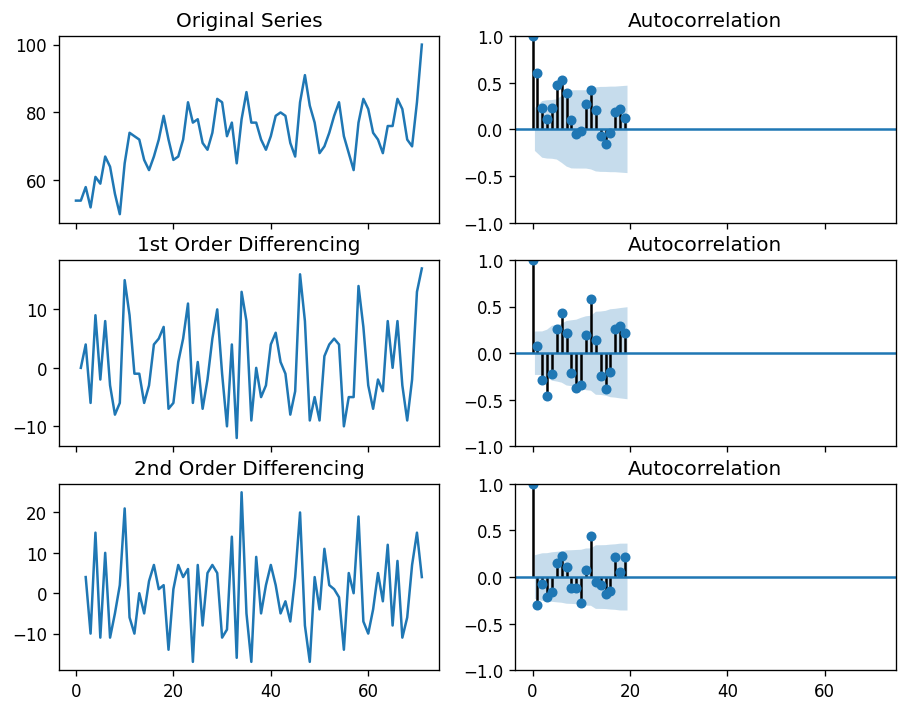

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.RelativeInterest); axes[0, 0].set_title('Original Series')
plot_acf(data.RelativeInterest, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.RelativeInterest.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.RelativeInterest.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.RelativeInterest.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.RelativeInterest.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


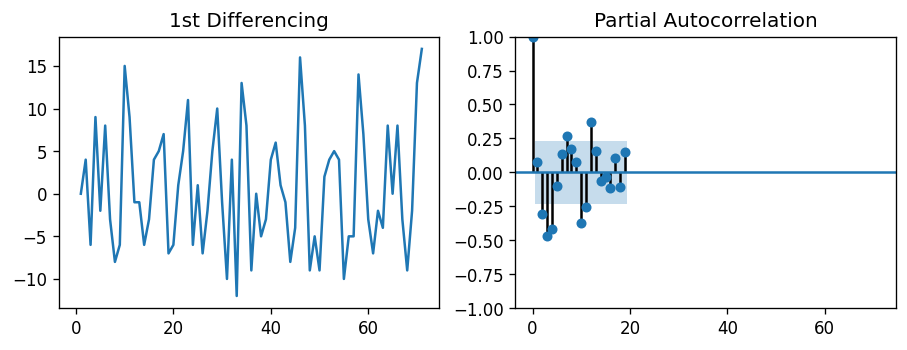

In [22]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.RelativeInterest.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.RelativeInterest.diff().dropna(), ax=axes[1])

plt.show()

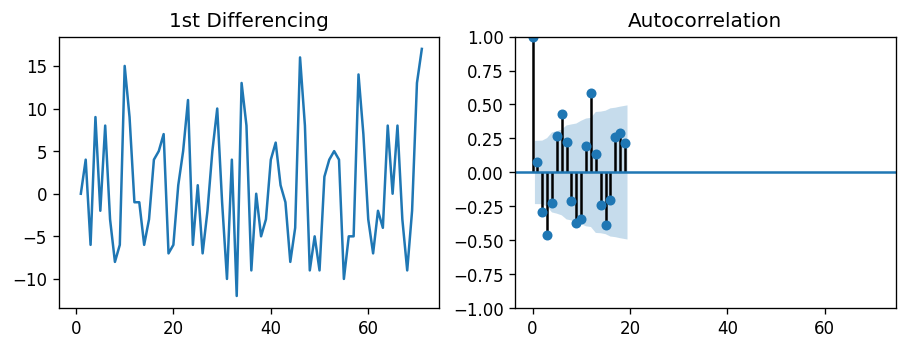

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.RelativeInterest.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.RelativeInterest.diff().dropna(), ax=axes[1])

plt.show()

In [46]:
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(data.RelativeInterest, order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())

NotImplementedError: ignored

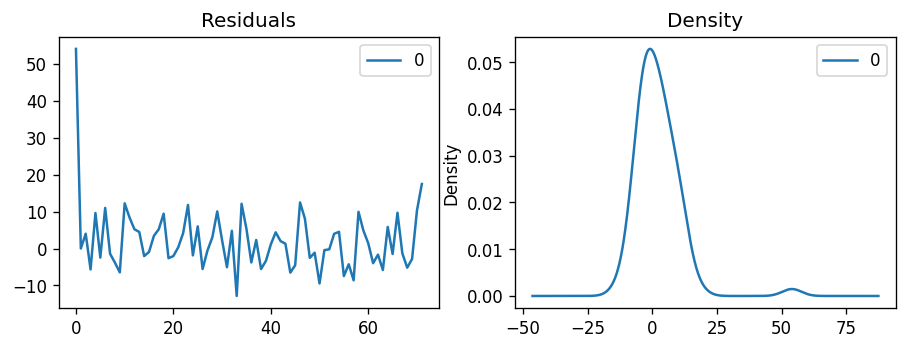

In [35]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [36]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: ignored

In [37]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = data.RelativeInterest[:35]
test = data.RelativeInterest[35:]

In [38]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3,2,1))  
fitted = model.fit()  

In [ ]:
fc, se, conf = fitted.forecast(37, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(37, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

In [48]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(data.RelativeInterest, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=487.582, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=484.907, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=486.445, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=486.022, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=483.487, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.171 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -240.744
Date:                Sun, 06 Nov 2022   AIC                            483.487
Time:                        19:04:03   BIC                            485.750
Sample:                             0   HQIC                           484.387
                                 - 72                                         
Co

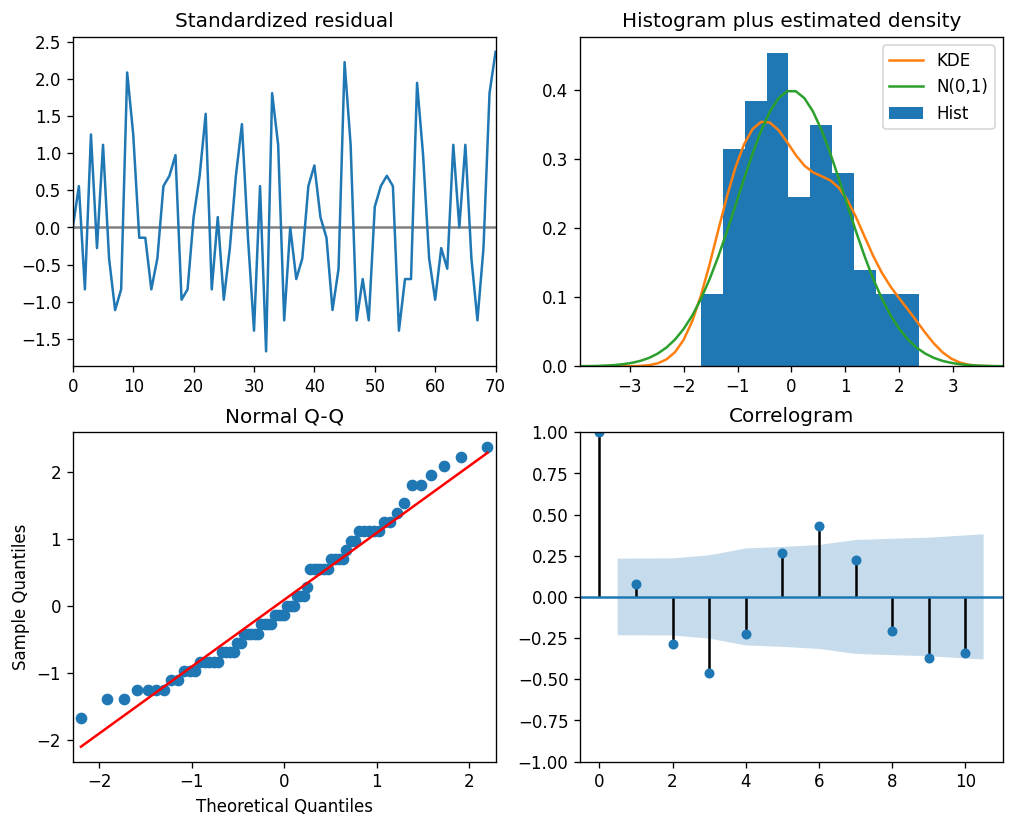

In [50]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

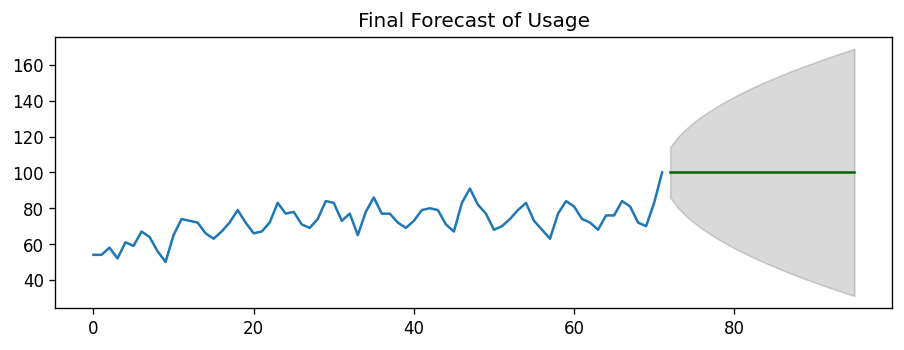

In [52]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data.RelativeInterest), len(data.RelativeInterest)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data.RelativeInterest)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

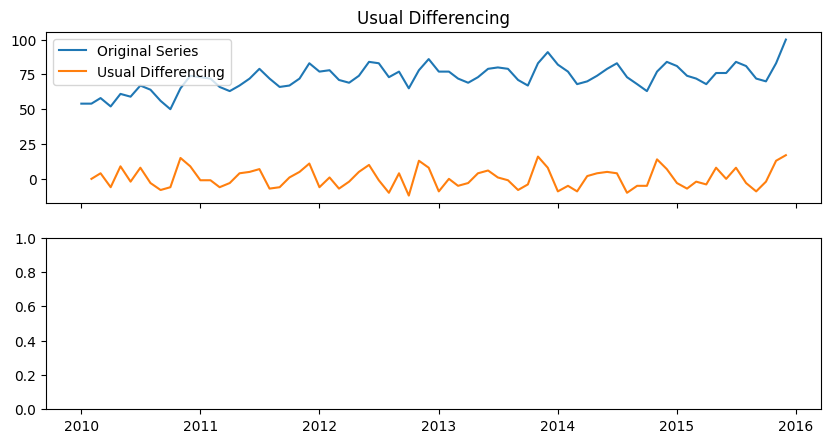

In [55]:
# Plot
#data = pd.read_csv('/kaggle/input/dataset/dataset.txt', parse_dates=['date'], index_col='date')
data=pd.read_csv(io.BytesIO(uploaded['WhiteWine.csv']), parse_dates=['date'], index_col='date')
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

In [56]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=339.855, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=367.481, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=344.406, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=338.389, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=349.049, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=341.133, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=339.783, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=340.307, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=339.192, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -166.194
Date:                            Sun, 06 Nov 2022   AIC                            338.389
Time:                                    19:11:10   BIC                            344.621
Sample:                                01-01-2010   HQIC                           340.822
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5451      0.149     -3.649      0.000      -0.838      -0.252
ma.S.L12      -0.8001      0.393     -2.036      0.042      -1.570      -0.030
sigma2        13.4254      3.927      3.418      0.001       5.728      21.123
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.44   Prob(JB):                         0.40
Heteroskedasticity (H):               0.58   Skew:                             0.42
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

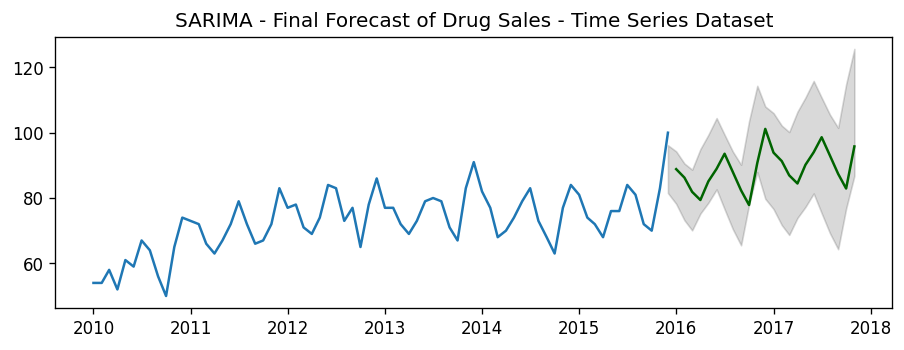

In [57]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

In [60]:

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['RelativeInterest'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['RelativeInterest', 'month', 'seasonal_index']
df.index = data.index  # reassign the index

In [62]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['RelativeInterest']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=339.855, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=367.481, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=344.406, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=338.389, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=349.049, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=341.133, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=339.783, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=340.307, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=339.192, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -166.194
Date:                            Sun, 06 Nov 2022   AIC                            338.389
Time:                                    19:14:17   BIC                            344.621
Sample:                                01-01-2010   HQIC                           340.822
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5451      0.149     -3.649      0.000      -0.838      -0.252
ma.S.L12      -0.8001      0.393     -2.036      0.042      -1.570      -0.030
sigma2        13.4254      3.927      3.418      0.001       5.728      21.123
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.44   Prob(JB):                         0.40
Heteroskedasticity (H):               0.58   Skew:                             0.42
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""